In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Concatenate
from tensorflow.keras.models import Model

## Equations of motion

In [189]:
n_dims = 2

k = -1.0
gamma = 1.0
m = 1

f_spring = lambda x: -(k*x + gamma*x**3)
V_spring = lambda x: (k/2)*x**2 + (gamma/4)*x**4

SHO_equations = lambda t, X: np.concatenate([(X[n_dims:2*n_dims]/m), (f_spring(X[0:n_dims]))])

## Dataset for learning

In [190]:
time_step = 0.1
N_train = 1000

X0_train = np.empty([N_train, 2*n_dims+1], dtype=np.float64)
X1_train = np.empty([N_train, 2*n_dims+1], dtype=np.float64)

for i in range(N_train):
    h = np.random.rand()*time_step*5
    X0 = 2*np.random.randn(2*n_dims)
    sol = solve_ivp(SHO_equations, [0,h], X0).y.transpose()
    
    X0_train[i] = np.insert(sol[0], 0, h)
    X1_train[i] = np.insert(sol[-1], 0, h)

## RK4 Solver

In [191]:
def rk4_step(dX_dt, n_params):
    
    in_tensor = Input(shape=(n_params+1,))
    
    h  = Lambda(lambda x: x[:,0:1]) (in_tensor) 
    X0 = Lambda(lambda x: x[:,1:])(in_tensor)
    
    k1 = dX_dt(X0)
    k2 = dX_dt(Add()([X0, Lambda(lambda k: (h/2)*k)(k1)]))
    k3 = dX_dt(Add()([X0, Lambda(lambda k: (h/2)*k)(k2)]))
    k4 = dX_dt(Add()([X0, Lambda(lambda k: h*k)(k3)]))
    
    k5 = Add()([k1,Lambda(lambda k: 2*k)(k2),
                Lambda(lambda k: 2*k)(k3),k4])
    
    dX = Lambda(lambda k: (h/6)*k)(k5)
    
    X1 = Add()([X0, dX])
    
    out_tensor = Concatenate()([h, X1])
    
    return Model(inputs=in_tensor, outputs=out_tensor)

## Time evolution models

In [192]:
gradients = Lambda(lambda x: tf.gradients(x[0],x[1])[0])

def potential_evolution(n_dims, Vq):
    X = Input(shape=(2*n_dims,))

    Q = Lambda(lambda x: x[:,0:n_dims])(X)
    P = Lambda(lambda x: x[:,n_dims:2*n_dims])(X)

    V = Vq(Q)
    T = Lambda(lambda p: tf.reduce_sum((1/(2*m))*p**2))(P)

    dPdt = Lambda(lambda x: tf.negative(x))(gradients((V,Q)))
    dQdt = gradients((T,P))
    
    dPQdt = Concatenate()([dQdt,dPdt])

    return Model(inputs=X, outputs=dPQdt)

def hamiltonian_evolution(n_dims, Hamiltonian):
    X = Input(shape=(2*n_dims,))

    Q = Lambda(lambda x: x[:,0:n_dims])(X)
    P = Lambda(lambda x: x[:,n_dims:2*n_dims])(X)
    
    H = Hamiltonian(Concatenate()([Q,P]))

    dPdt = Lambda(lambda x: tf.negative(x))(gradients((H,Q)))
    dQdt = gradients((H,P))
    
    dPQdt = Concatenate()([dQdt,dPdt])

    return Model(inputs=X, outputs=dPQdt)

In [149]:
class swish_layer(keras.layers.Layer):

    def __init__(self, units, w_scale = 1.0, reg_scale=0.0, **kwargs):
        self.units = units
        self.swish = lambda x: K.sigmoid(x) * x
        
        self.k_init = keras.initializers.RandomUniform(-w_scale, w_scale)
        self.b_init = keras.initializers.RandomUniform(-w_scale, w_scale)
        
        self.k_regularizer = keras.regularizers.l2(reg_scale)
        self.b_regularizer = keras.regularizers.l2(reg_scale)
        
        super(swish_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      regularizer=self.k_regularizer,
                                      initializer=self.k_init)
        
        self.bias = self.add_weight(name='bias', 
                                    shape=(self.units,),
                                    regularizer=self.b_regularizer,
                                    initializer=self.b_init)
        
        super(swish_layer, self).build(input_shape)

    def call(self, x):
        output = self.swish(K.dot(x, self.kernel))
        output = K.bias_add(output, self.bias)
        return self.swish(output)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
def swish_mlp(input_dim, output_dim, layers,
              reg_scale = 0.01, weight_scale = 1.0):
    
    X = [Input(shape=(input_dim,))]
    
    for i, layer in enumerate(layers):
        X += [swish_layer(layer)(X[i])]
    
    X += [swish_layer(output_dim)(X[i])]
    
    return Model(inputs=X[0], outputs=X[-1])

In [237]:
#V_NN = swish_mlp(n_dims, 1, [10,20,10],
#               reg_scale=0.0, weight_scale = 1.0)

H_NN = swish_mlp(2*n_dims, 1, [10,100,100,10],
               reg_scale=0.0, weight_scale = 1.0)

#H_NN = keras.models.Sequential()
#H_NN.add(Dense(10, input_dim=2*n_dims,
#               activation='tanh', bias_initializer='glorot_uniform'))
#H_NN.add(Dense(20, activation='tanh',
#               bias_initializer='glorot_uniform'))
#H_NN.add(Dense(10, activation='tanh',
#               bias_initializer='glorot_uniform'))
#_NN.add(Dense(1, activation='tanh', bias_initializer='glorot_uniform'))

## Solving the system

In [238]:
#dX_dt = potential_evolution(n_dims, V_NN)

dX_dt = hamiltonian_evolution(n_dims, H_NN)
model = rk4_step(dX_dt, 2*n_dims)

In [239]:
def MSE(y_true, y_pred):
    return K.mean(K.square(y_pred[:,1:] - y_true[:,1:]), axis=-1)

def ME(y_true, y_pred):
    return K.mean(K.abs(y_pred[:,1:] - y_true[:,1:]), axis=-1)

model.compile(optimizer=keras.optimizers.Nadam(),
                loss=ME, metrics=['mse'])

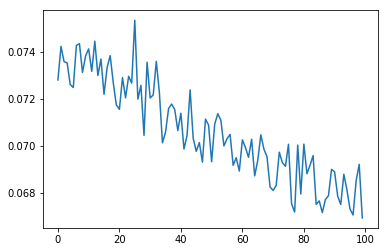

In [261]:
result = model.fit(x=X0_train, y=X1_train,
                  batch_size=100, epochs=100, shuffle=True, verbose=0)

plt.plot(result.history['loss'])
plt.show()

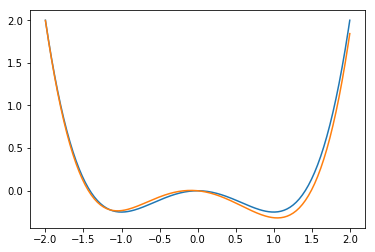

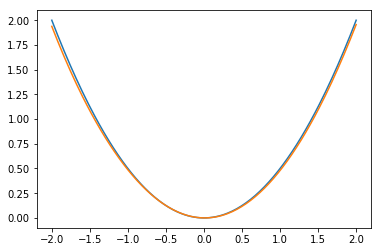

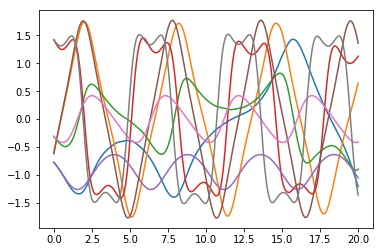

In [262]:
N_points = 200

q = np.linspace(-2,2,N_points)
plt.plot(q, V_spring(q))



V0 = H_NN.predict(np.array([[0,0,0,0]]))
plt.plot(q, H_NN.predict(np.column_stack((q,np.zeros(N_points),np.zeros(N_points),np.zeros(N_points))))-V0)
plt.show()

p = np.linspace(-2,2,N_points)
plt.plot(p, p**2/(2*m))
V0 = H_NN.predict(np.array([[0,0,0,0]]))
plt.plot(q, H_NN.predict(np.column_stack((np.zeros(N_points),np.zeros(N_points),np.zeros(N_points),p)))-V0)
plt.show()

x0 = np.random.randn(2*n_dims)
xp = np.insert(x0, 0, time_step).reshape((1,1+2*n_dims))
t = np.linspace(0,time_step*N_points,N_points)
x = []
for i in range (N_points):
    x += [xp[0][1:]]
    xp = model.predict([xp])

sol = solve_ivp(SHO_equations, [0,time_step*N_points], x0, t_eval=t).y.transpose()
    
plt.plot(t, np.array(x))
plt.plot(t, sol)
plt.show()

ValueError: Error when checking input: expected input_30 to have shape (4,) but got array with shape (2,)

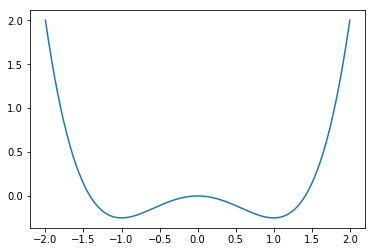

In [219]:
N_points = 200

q = np.linspace(-2,2,N_points)
plt.plot(q, V_spring(q))
V0 = H_NN.predict(np.array([[0,0]]))
plt.plot(q, H_NN.predict(np.column_stack((q,np.zeros(N_points))))-V0)
plt.show()

p = np.linspace(-2,2,N_points)
plt.plot(p, p**2/(2*m))
V0 = H_NN.predict(np.array([[0,0]]))
plt.plot(q, H_NN.predict(np.column_stack((np.zeros(N_points),p)))-V0)
plt.show()

x0 = np.random.randn(2*n_dims)
xp = np.insert(x0, 0, time_step).reshape((1,1+2*n_dims))
t = np.linspace(0,time_step*N_points,N_points)
x = []
for i in range (N_points):
    x += [xp[0][1:]]
    xp = model.predict([xp])

sol = solve_ivp(SHO_equations, [0,time_step*N_points], x0, t_eval=t).y.transpose()
    
plt.plot(t, np.array(x))
plt.plot(t, sol)
plt.show()

plt.plot(sol[:,0],sol[:,1])
plt.plot(np.array(x)[:,0],np.array(x)[:,1])

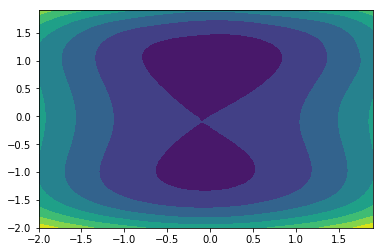

In [188]:
q = np.arange(-2, 2, 0.1)
p = np.arange(-2, 2, 0.1)

V0 = H_NN.predict(np.array([[0,0]]))

H = np.empty((len(q),len(p)))
for i,x in enumerate(q):
    for j,y in enumerate(p):
        H[i,j] = H_NN.predict(np.array([[x,y]]))[0,0]-V0

plt.contourf(q,p,H)